# Car Make Classifier: Full Scale

In the modern automotive industry, visual brand identity plays a crucial role. Each car manufacturer designs vehicles with unique styling elements—from grille shape to headlight design—that make their cars instantly recognizable. 

In this project, we aim to harness the power of image classification using deep learning to build a model that can automatically identify whether a car in an image belongs to BMW, Porsche, Toyota, Peugeut, Tesla, Audi, etc.

### 🎯 Objective
For the initial model we are going to feed it with images from one of the most immediatelly recognizable cars: **Audi**, **BMW** and **Mercedes**.

The goal is to develop a machine learning model that takes a full image of a car and correctly classifies it as one of the brands from above. The model will be trained on a curated image dataset and evaluated on its ability to generalize to new, unseen car images.

### 🔗 How We Combine SVC and TensorFlow/CNN - Project Approach Idea


In this project, we use a **hybrid approach** that leverages the strengths of both deep learning and classical machine learning:

1. **Feature Extraction with CNN (TensorFlow/MobileNetV2):**
    - We use a pre-trained convolutional neural network (CNN), specifically MobileNetV2, to process each car image.
    - The CNN is not trained from scratch; instead, we use its learned filters to extract high-level, abstract features from the images.
    - The output for each image is a compact feature vector (not a class prediction), which captures important visual patterns.

2. **Classification with SVC (Support Vector Classifier):**
    - The feature vectors extracted by the CNN are used as input to a Support Vector Classifier (SVC), a classical machine learning algorithm.
    - The SVC learns to separate the feature vectors into different car brands (Audi, BMW, Mercedes) based on the patterns learned by the CNN.

**Why this combination?**
- CNNs are excellent at extracting meaningful features from images, even with limited data, when using pre-trained models.
- SVCs are effective at finding decision boundaries in lower-dimensional feature spaces, especially with small to medium-sized datasets.
- This hybrid approach allows us to benefit from deep learning's representational power without needing a huge labeled dataset or extensive training time.

**Workflow Recap:**
1. Images → MobileNetV2 (CNN) → Feature Vectors
2. Feature Vectors → SVC → Brand Prediction

This method is often called "transfer learning with classical classifier" and is widely used when data is limited but high-quality pre-trained models are available.

-----

## 🌐 Domain Context
In today's digital landscape, apps that leverage computer vision are becoming increasingly prevalent across industries — from retail and security to automotive technology. Within the automotive domain, identifying the make of a vehicle from a photo has practical value in multiple applications: car listing platforms, mobile parking apps, AI-powered insurance inspections, and even driver-assistance systems.

Ultimately, this project demonstrates how AI can bridge the gap between real-world visual data and intelligent brand recognition, opening the door for smarter, image-driven applications in the automotive and consumer tech space.

In [1]:
import copy, pathlib, math
import PIL.Image as Image

import sklearn
import numpy
import matplotlib
import matplotlib.pyplot as plt

print("scikit-learn version:", sklearn.__version__)     # 1.2.2
print("numpy version:", numpy.__version__)              # 2.1.3
print("matplotlib version:", matplotlib.__version__)    # 3.10.2

scikit-learn version: 1.7.0
numpy version: 2.1.3
matplotlib version: 3.10.3


## 📦 Data Provisioning

For this project, the dataset was curated from various sources on the internet. Images representing three car brands—**Audi**, **BMW**, and **Mercedes**—were collected. The dataset includes a mix of clear, high-quality images typically used for car listings, as well as blurrier images captured from traffic cameras to ensure diversity and robustness in the model.

- **Brands:** Audi, BMW, Mercedes  
- **Image Count:** At least 50 images per brand, with some brands having more  
- **Image Variety:** Both clear/listing images and real-world, lower-quality images

All images are organized in subfolders named after their respective brands. This structure allows for straightforward loading and labeling during the data preparation phase. 

In [2]:
import os
from PIL import Image, UnidentifiedImageError


input_root = "car_dataset"
output_size = (224, 224)
accepted_formats = ('.jpg', '.jpeg', '.png')


for brand in os.listdir(input_root):
    brand_path = os.path.join(input_root, brand)
    if not os.path.isdir(brand_path):
        continue

    print(f"Processing: {brand}")
    count = 1 #Count for renaming the file names

    for filename in os.listdir(brand_path):
        file_path = os.path.join(brand_path, filename)

       # Checking if the file is an image based on its extension
        if not filename.lower().endswith(accepted_formats):
            print(f"Skipping non-image: {filename}")
            continue

        try:
            with Image.open(file_path) as img:
                img = img.convert("RGB") # Converting to RGB in case of PNG or other formats
                img = img.resize(output_size) # Resizing the images to 224x224

                new_filename = f"{brand.lower()}_{count:03}.jpg" # changing the name of the folder
                new_path = os.path.join(brand_path, new_filename)
                img.save(new_path, "JPEG")

                if filename != new_filename:
                    os.remove(file_path)

                count += 1

        except (UnidentifiedImageError, OSError) as e: #In case of corrupted images
            print(f"Removing corrupted file: {filename}")
            os.remove(file_path)

Processing: audi
Processing: bmw
Processing: mercedes


In [3]:
for brand in os.listdir("car_dataset"):
    print(f"{brand} has {len(os.listdir(os.path.join(input_root, brand)))} images.")

audi has 66 images.
bmw has 58 images.
mercedes has 55 images.


# 📃 Sample the data
To get an impression of the data, here a sample from the loaded images is plotted so see if they we loaded correctly.

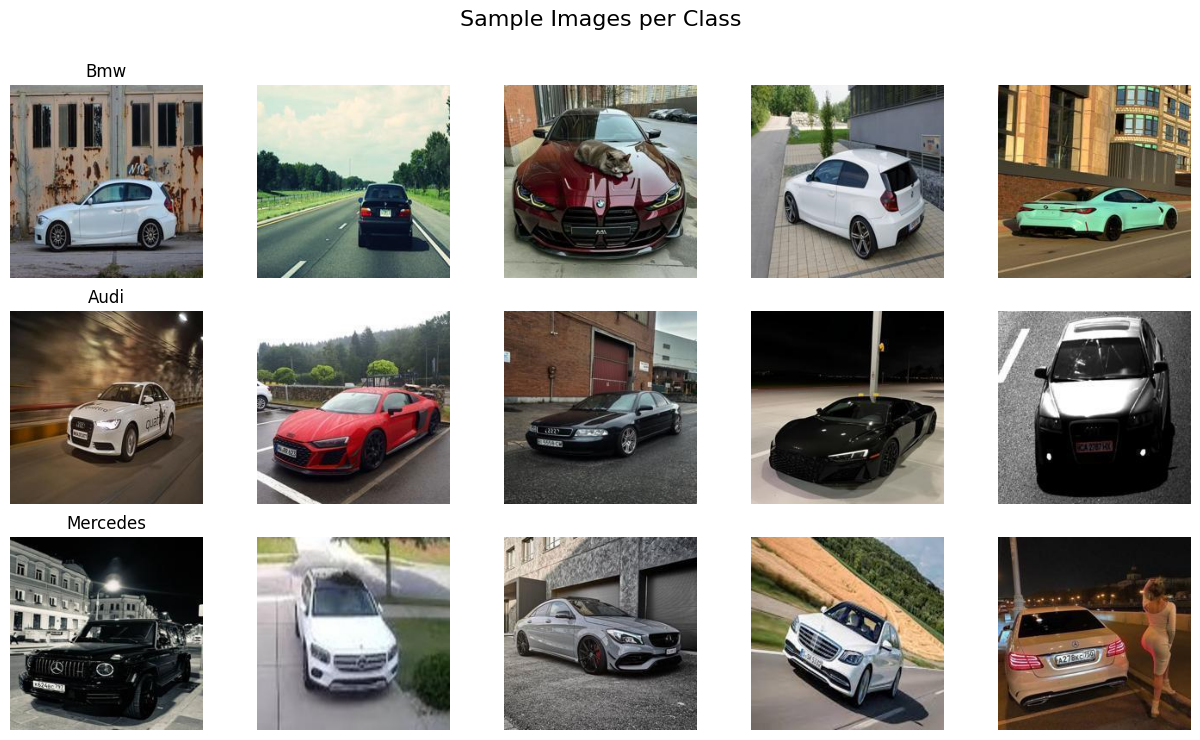

In [4]:
import random

classes = ["bmw", "audi", "mercedes"]
images_per_class = 5

fig, axes = plt.subplots(len(classes), images_per_class, figsize=(images_per_class * 2.5, len(classes) * 2.5))
fig.suptitle("Sample Images per Class", fontsize=16)

for row, cls in enumerate(classes):
    class_dir = os.path.join(input_root, cls)
    images = [f for f in os.listdir(class_dir) if f.lower().endswith(".jpg")]
    sampled = random.sample(images, min(images_per_class, len(images)))

    for col, img_file in enumerate(sampled):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path).resize(output_size)

        ax = axes[row][col] if len(classes) > 1 else axes[col]
        ax.imshow(img)
        ax.axis("off")
        if col == 0:
            ax.set_title(cls.capitalize(), fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


## 🧠 Feature Extraction with TensorFlow and Hybrid Modeling

In this section, we leverage TensorFlow, a powerful open-source deep learning framework, to extract high-level features from our car images using a pre-trained convolutional neural network (CNN). TensorFlow is widely used for building and training neural networks due to its flexibility, scalability, and strong support for GPU acceleration.

Instead of training a deep neural network from scratch (which requires a large dataset and significant computational resources), we use a pre-trained model (MobileNetV2) as a feature extractor. This model has already learned to recognize a wide variety of visual patterns from millions of images. By passing our car images through MobileNetV2 (excluding its final classification layer), we obtain compact and informative feature vectors that represent each image.

These feature vectors are then used as input to a Support Vector Classifier (SVC), a classical machine learning algorithm. This hybrid approach combines the representational power of deep learning (for feature extraction) with the simplicity and effectiveness of SVC (for classification), making it well-suited for our relatively small dataset.

In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tqdm import tqdm

image_size = (224, 224)
dataset_path = "car_dataset"

X = []
y = []
class_labels = {"audi": 0, "bmw": 1, "mercedes": 2}

for label in class_labels:
    folder = os.path.join(dataset_path, label)
    for img_name in tqdm(os.listdir(folder), desc=f"Loading {label}"):
        try:
            img_path = os.path.join(folder, img_name)
            img = load_img(img_path, target_size=image_size)
            img_array = img_to_array(img)
            img_array = preprocess_input(img_array)
            X.append(img_array)
            y.append(class_labels[label])
        except Exception as e:
            print(f"Skipped {img_name}: {e}")


Loading mercedes: 100%|██████████| 55/55 [00:01<00:00, 40.78it/s]


Next, we convert the lists of image arrays (`X`) and labels (`y`) into NumPy arrays, which are required for efficient processing with deep learning models. We then load the pre-trained MobileNetV2 model from Keras, excluding its top classification layer and using global average pooling. This model is used to extract high-level feature vectors from each image in our dataset. By passing our images through MobileNetV2, we obtain a compact representation (`features`) for each image, which will be used as input for our machine learning classifier.

In [6]:
X = np.array(X)
y = np.array(y)

from tensorflow.keras.applications import MobileNetV2

mobilenet = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
features = mobilenet.predict(X, verbose=1)


6/6 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step 


Now the feature vectors extracted by the CNN are used as input to a Support Vector Classifier (SVC). Let's model it.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)

clf = SVC(C=1.0, kernel='rbf', probability=True)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_labels.keys()))
print("Model accuracy:", score)


              precision    recall  f1-score   support

        audi       0.40      0.77      0.53        13
         bmw       0.60      0.25      0.35        12
    mercedes       0.50      0.27      0.35        11

    accuracy                           0.44        36
   macro avg       0.50      0.43      0.41        36
weighted avg       0.50      0.44      0.42        36

Model accuracy: 0.4444444444444444


The biggest problem we see is with mercedes: Struggling at 0.27 recall. One main reason is probably the fact that out of the three car brands Audi has the most images and here we clearly see that the more images we add to each car brand, the better the selection from CNN.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


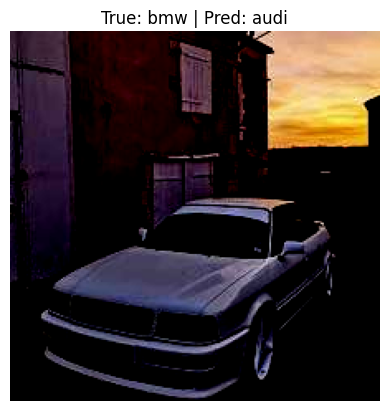

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


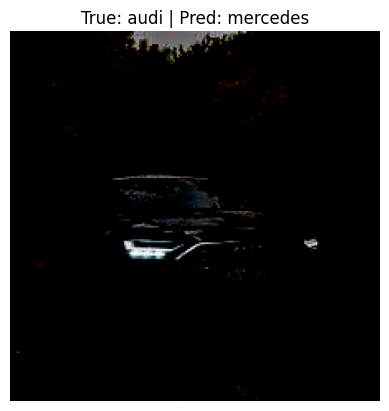

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


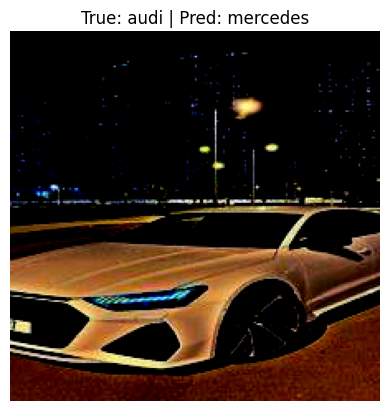

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


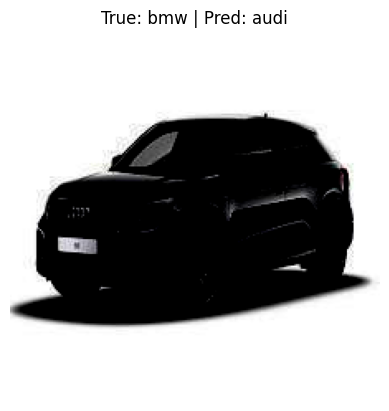

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


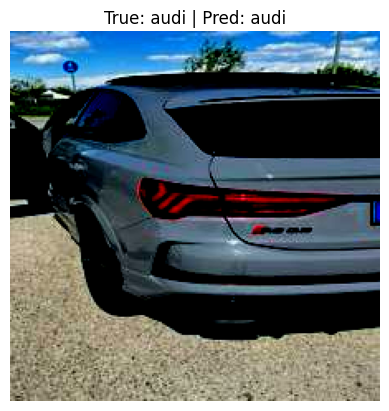

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


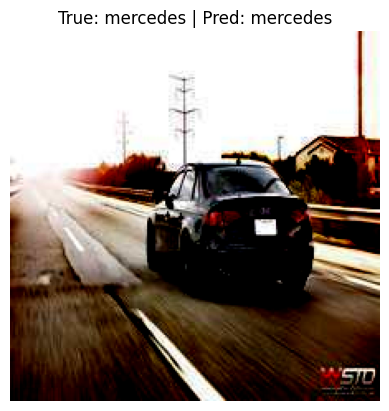

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


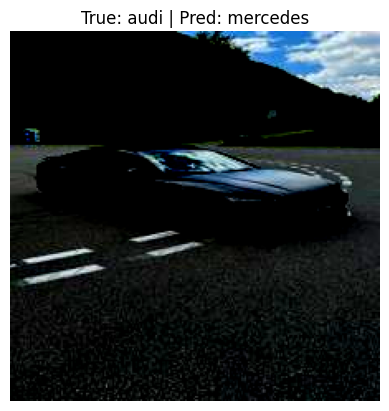

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


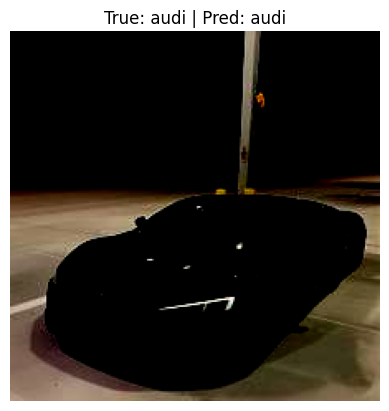

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


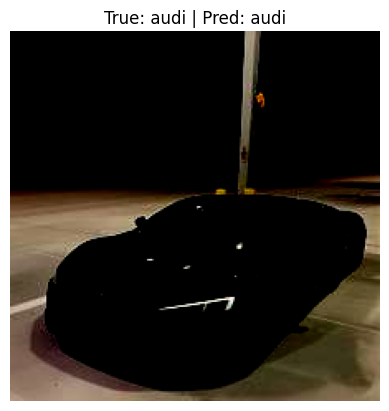

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


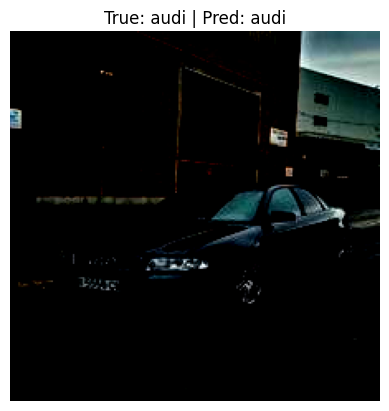

In [8]:
import matplotlib.pyplot as plt

inv_class_labels = {v: k for k, v in class_labels.items()}

for i in range(10):
    idx = np.random.randint(0, len(y_test))
    true_label = inv_class_labels[y_test[idx]]
    pred_label = inv_class_labels[y_pred[idx]]
    
    plt.imshow(X[idx])
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(probability=True), param_grid, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)
print("Best score from grid search:", grid_score)

print("Best params:", grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred, target_names=class_labels.keys()))


Best score from grid search: 0.3888888888888889
Best params: {'C': 5, 'gamma': 'auto', 'kernel': 'rbf'}
              precision    recall  f1-score   support

        audi       0.36      0.62      0.46        13
         bmw       0.50      0.25      0.33        12
    mercedes       0.38      0.27      0.32        11

    accuracy                           0.39        36
   macro avg       0.41      0.38      0.37        36
weighted avg       0.41      0.39      0.37        36



Even with the best hyperparameters found via grid search (C=5, gamma='auto', kernel='rbf'), the SVM still struggles with BMW and Mercedes images. This is happening probably because there is too little training data — we are not even using 100 images per car brand and real-world car images have a ton of variability (angles, lighting, logos hidden, etc.).
Also it must be noted that BMW and Mercedes cars can look very similar to a classifier.

That may be the only possibility because regarding SVM — we may have hit the limit of what a fixed-feature SVM model can do without additional data or a more flexible learner.

In [10]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the SVC using the extracted features
cv_scores = cross_val_score(clf, features, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))

Cross-validation scores: [0.44444444 0.38888889 0.41666667 0.44444444 0.31428571]
Mean CV accuracy: 0.40174603174603174


Cross-validation was performed using 5 folds to assess model stability. The individual fold scores ranged from 31% to 44%, with a mean accuracy of ~40.17%. This variation indicates the model’s performance is inconsistent across different subsets of the data. The relatively low scores suggest limited generalization, likely due to dataset noise, small sample size, and class imbalance.

📊 Model Evaluation and Interpretation
The Support Vector Machine (SVM) classifier achieved an average cross-validation accuracy of approximately 40% across five folds. The per-class performance indicates a noticeable imbalance, with the model being more confident in classifying Audi images while struggling with BMW and Mercedes. This suggests some bias in the learned features, likely due to inconsistencies in the dataset such as uneven image quality, unbalanced class distributions, and the presence of visual noise (e.g., low-resolution, obscured logos, or unusual angles).

Furthermore, the relatively small size of the dataset (only ~100 images per brand) limits the model’s ability to generalize well to unseen data. Given the subtle visual differences between car brands in real-world scenarios—especially when logos are not visible—a more robust solution would require a larger, cleaner, and more diverse dataset.

🧾 Project Summary
Over the course of two weeks, we developed a machine learning pipeline to classify real-world car images into three major brands: Audi, BMW, and Mercedes. The project involved manually sourcing and organizing images, preprocessing them, extracting deep visual features using MobileNetV2, and training a Support Vector Machine (SVM) for classification. Despite the challenges of working with a small and noisy dataset, we successfully implemented a full image classification workflow and achieved reasonable baseline results.

The current model, while limited in accuracy, demonstrates the feasibility of car brand recognition using pre-trained CNN features. With more time and resources, this project could evolve into a highly accurate and scalable system by incorporating more training data, data augmentation, and potentially fine-tuning a full CNN model. This groundwork provides a solid foundation for future improvements and real-world deployment scenarios, such as traffic monitoring, vehicle cataloging, or mobile recognition apps.